In [32]:
import os
import joblib
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from scipy.stats import skew
#from numba import generated_jit
import warnings
warnings.filterwarnings('ignore')

### Data Understanding

In [33]:
df = pd.read_csv('data/credit_dataset.csv')
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    int64  
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    int64  
 4   BankCustomer    690 non-null    int64  
 5   Industry        690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    int64  
 9   Employed        690 non-null    int64  
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    int64  
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    int64  
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 86.4+ KB


In [35]:
#Check if there are null values
df.isnull().sum()


Gender            0
Age               0
Debt              0
Married           0
BankCustomer      0
Industry          0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
Approved          0
dtype: int64

### Data Cleaning

In [36]:
# Remove useless collumns
df.drop(columns=["ZipCode", "DriversLicense"], axis=1, inplace=True)


In [37]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,ByOtherMeans,0,1


In [38]:
df.nunique()

Gender             2
Age              350
Debt             215
Married            2
BankCustomer       2
Industry          14
Ethnicity          5
YearsEmployed    132
PriorDefault       2
Employed           2
CreditScore       23
Citizen            3
Income           240
Approved           2
dtype: int64

In [39]:
# Check if there are duplicates
df.duplicated().value_counts()

False    690
Name: count, dtype: int64

### EDA

In [40]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,ByOtherMeans,0,1


In [41]:
df.tail()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
685,1,21.08,10.085,0,0,Education,Black,1.25,0,0,0,ByBirth,0,0
686,0,22.67,0.750,1,1,Energy,White,2.00,0,1,2,ByBirth,394,0
687,0,25.25,13.500,0,0,Healthcare,Latino,2.00,0,1,1,ByBirth,1,0
688,1,17.92,0.205,1,1,ConsumerStaples,White,0.04,0,0,0,ByBirth,750,0
689,1,35.00,3.375,1,1,Energy,Black,8.29,0,0,0,ByBirth,0,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         690 non-null    int64  
 1   Age            690 non-null    float64
 2   Debt           690 non-null    float64
 3   Married        690 non-null    int64  
 4   BankCustomer   690 non-null    int64  
 5   Industry       690 non-null    object 
 6   Ethnicity      690 non-null    object 
 7   YearsEmployed  690 non-null    float64
 8   PriorDefault   690 non-null    int64  
 9   Employed       690 non-null    int64  
 10  CreditScore    690 non-null    int64  
 11  Citizen        690 non-null    object 
 12  Income         690 non-null    int64  
 13  Approved       690 non-null    int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 75.6+ KB


In [43]:
[c for c in df.columns if df[c].dtype=="object"]

['Industry', 'Ethnicity', 'Citizen']

In [44]:
df.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,Income,Approved
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,0.695652,31.514116,4.758725,0.760870,0.763768,2.223406,0.523188,0.427536,2.40000,1017.385507,0.444928
std,0.460464,11.860245,4.978163,0.426862,0.425074,3.346513,0.499824,0.495080,4.86294,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,1.000000,1.000000,0.165000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,28.460000,2.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,1.000000,1.000000,2.625000,1.000000,1.000000,3.00000,395.500000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.00000,100000.000000,1.000000


In [45]:
df.shape

(690, 14)

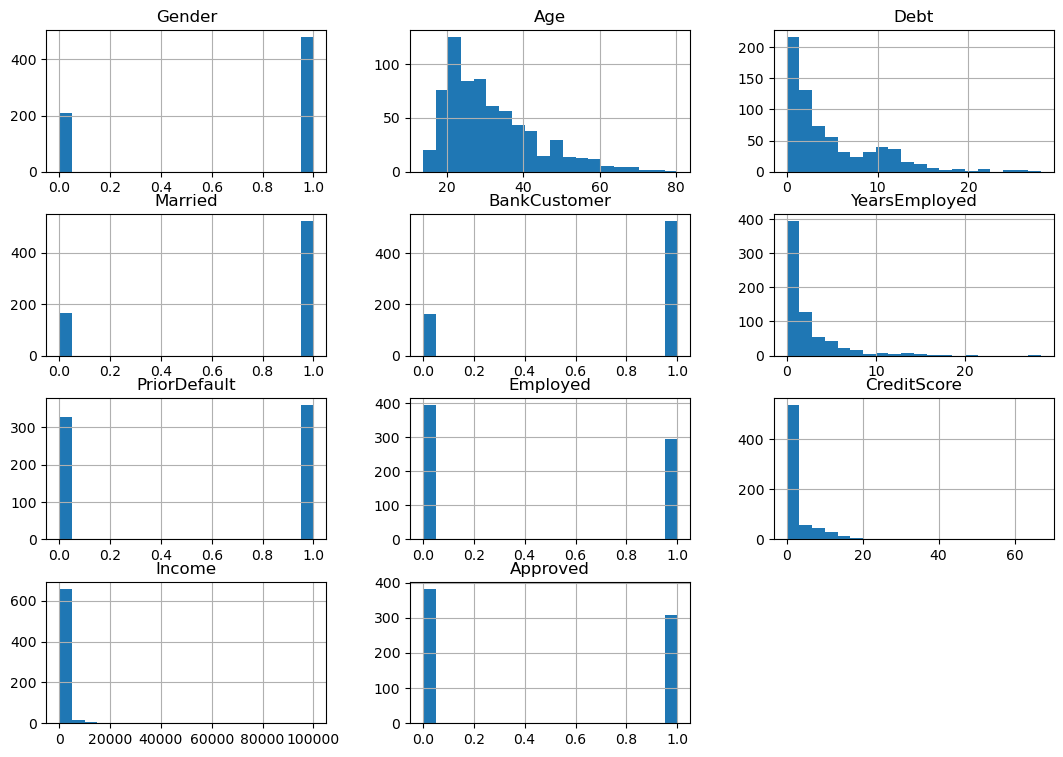

In [46]:
# Create histogram for numerical collumns
df.hist(figsize=(13, 9), bins=20)
plt.show()

In [47]:
print(f"Skewness for Age: {skew(df['Age'])}")
print(f"Skewness for Debt: {skew(df['Debt'])}")
print(f"Skewness for CreditScore: {skew(df['CreditScore'])}")



Skewness for Age: 1.1647650704131591
Skewness for Debt: 1.4855746179702647
Skewness for CreditScore: 5.141311956483638


In [48]:
df["Debt"] = np.log1p(df["Debt"])
df["Age"] = np.sqrt(df["Age"])
df["CreditScore"] = np.log1p(df["CreditScore"])


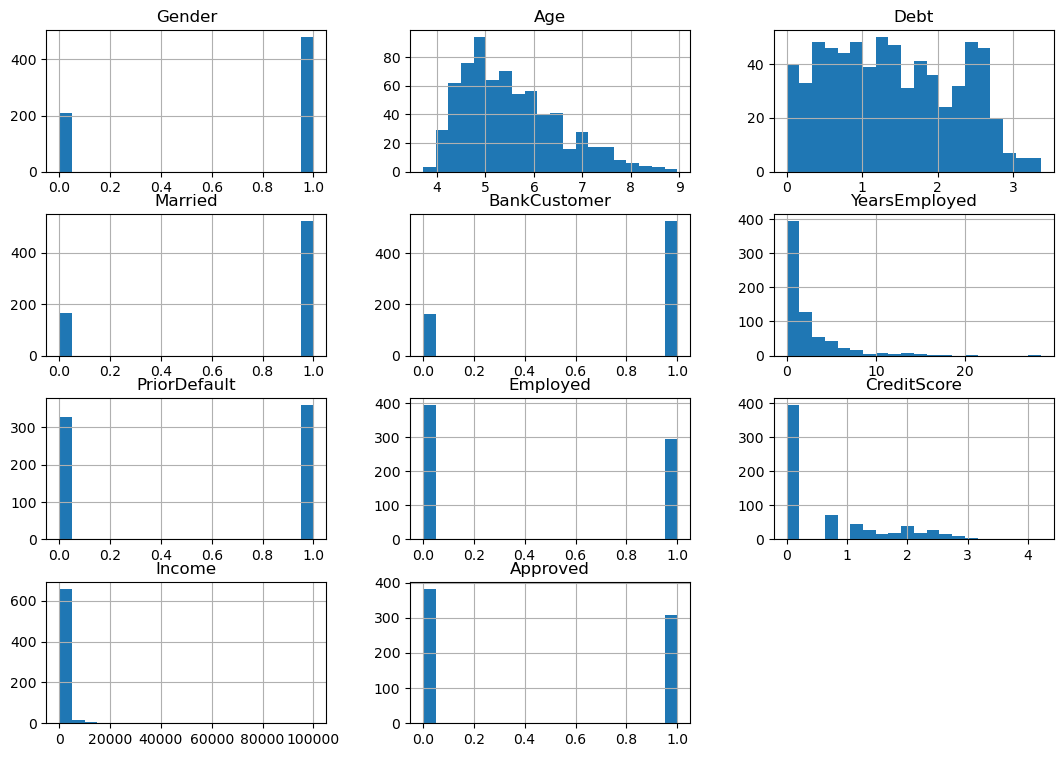

In [49]:
df.hist(figsize=(13, 9), bins=20)
plt.show()

In [50]:
print(f"Skewness pentru Age: {skew(df['Age'])}")
print(f"Skewness pentru Debt: {skew(df['Debt'])}")
print(f"Skewness pentru CreditScore: {skew(df['CreditScore'])}")

Skewness pentru Age: 0.7662257161012171
Skewness pentru Debt: 0.1721318192512319
Skewness pentru CreditScore: 1.0486272251231317


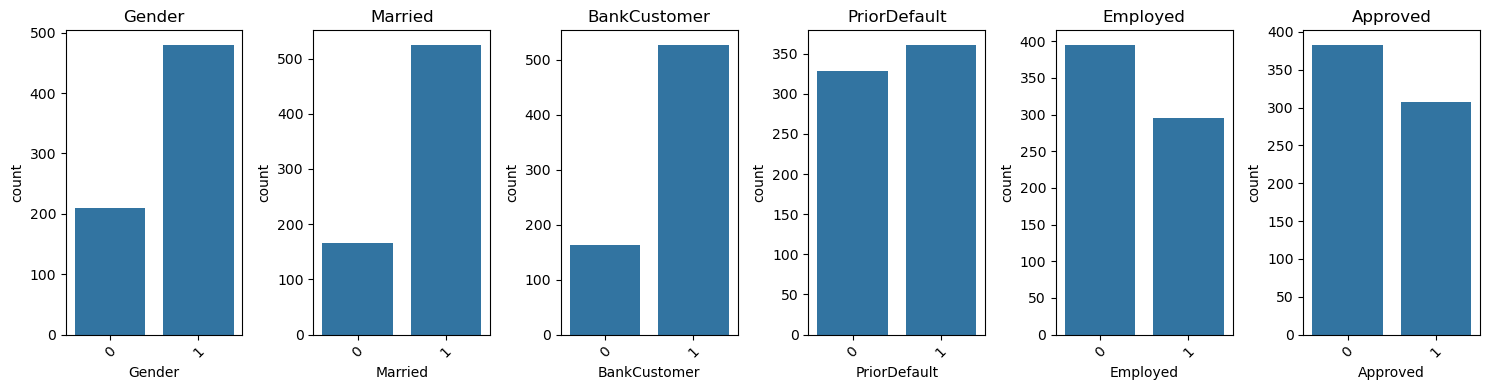

In [51]:
binary_cols = ["Gender", "Married", "BankCustomer", "PriorDefault", "Employed", "Approved"]

fig, axes = plt.subplots(1, len(binary_cols), figsize=(15, 4))

for i, col in enumerate(binary_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


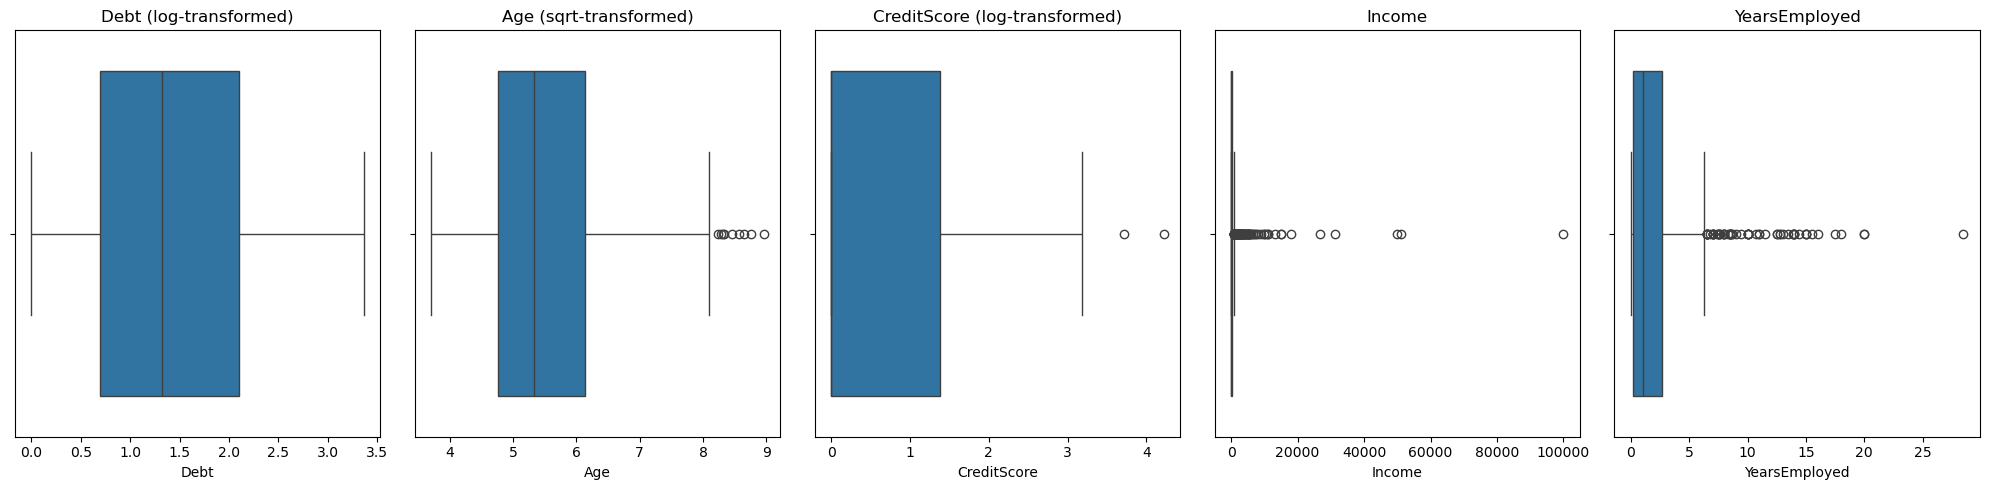

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(x=df["Debt"], ax=axes[0])
axes[0].set_title("Debt (log-transformed)")

sns.boxplot(x=df["Age"], ax=axes[1])
axes[1].set_title("Age (sqrt-transformed)")

sns.boxplot(x=df["CreditScore"], ax=axes[2])
axes[2].set_title("CreditScore (log-transformed)")

sns.boxplot(x=df["Income"], ax=axes[3])
axes[3].set_title("Income")

sns.boxplot(x=df["YearsEmployed"], ax=axes[4])
axes[4].set_title("YearsEmployed")

plt.tight_layout()
plt.show()

In [53]:
df["Income"] = np.log1p(df["Income"])
df["YearsEmployed"] = np.log1p(df["YearsEmployed"])


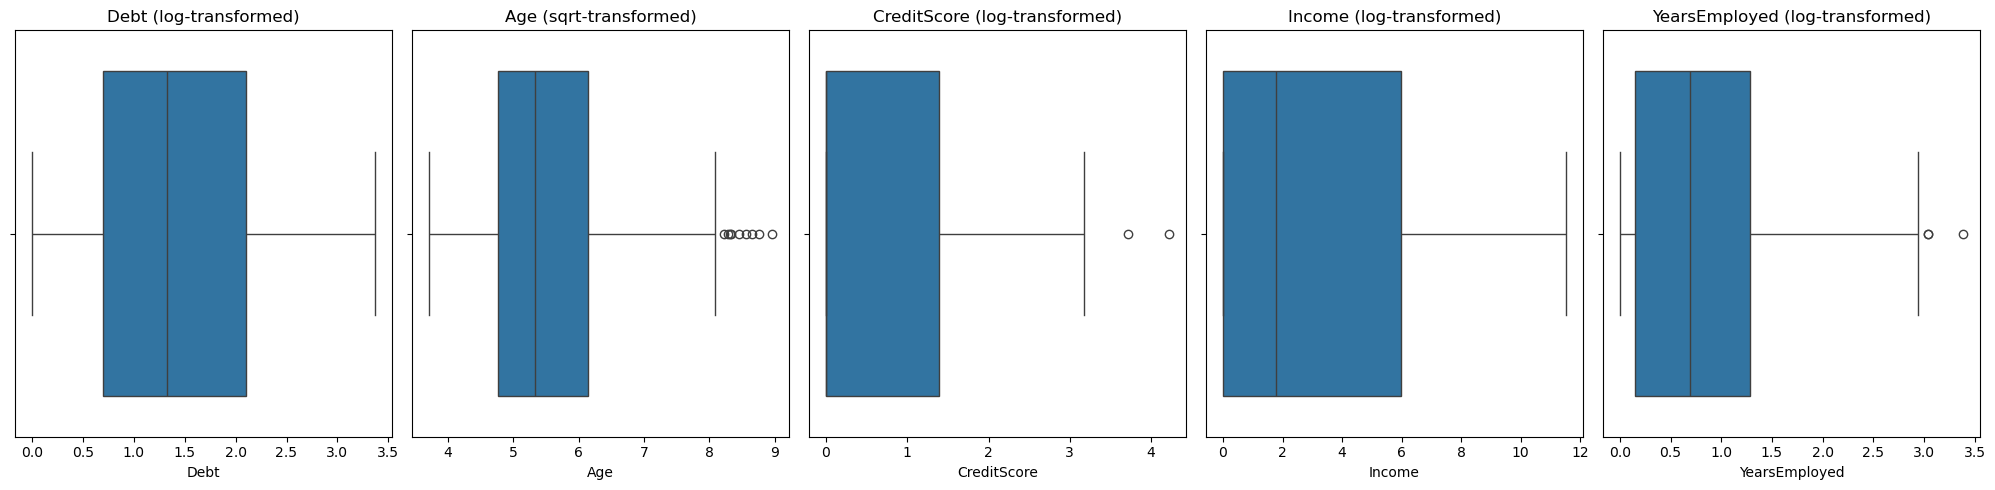

In [54]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(x=df["Debt"], ax=axes[0])
axes[0].set_title("Debt (log-transformed)")

sns.boxplot(x=df["Age"], ax=axes[1])
axes[1].set_title("Age (sqrt-transformed)")

sns.boxplot(x=df["CreditScore"], ax=axes[2])
axes[2].set_title("CreditScore (log-transformed)")

sns.boxplot(x=df["Income"], ax=axes[3])
axes[3].set_title("Income (log-transformed)")

sns.boxplot(x=df["YearsEmployed"], ax=axes[4])
axes[4].set_title("YearsEmployed (log-transformed)")

plt.tight_layout()
plt.show()

In [55]:
non_binary_cols=[c for c in df.columns if df[c].dtype=="object"]
print("Non-binary cols:", non_binary_cols)

Non-binary cols: ['Industry', 'Ethnicity', 'Citizen']


In [56]:
# Apply Encoder function
def ApplyEncoder(df, column):
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    return df

In [57]:
for col in non_binary_cols:
    df = ApplyEncoder(df, col)


In [58]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,Approved
0,1,5.552477,0.000000,1,1,7,4,0.810930,1,1,0.693147,0,0.000000,1
1,0,7.659634,1.697449,1,1,9,1,1.396245,1,1,1.945910,0,6.329721,1
2,0,4.949747,0.405465,1,1,9,1,0.916291,1,0,0.000000,0,6.715383,1
3,1,5.275415,0.932164,1,1,7,4,1.558145,1,1,1.791759,0,1.386294,1
4,1,4.491102,1.890850,1,1,7,4,0.996949,1,0,0.000000,1,0.000000,1


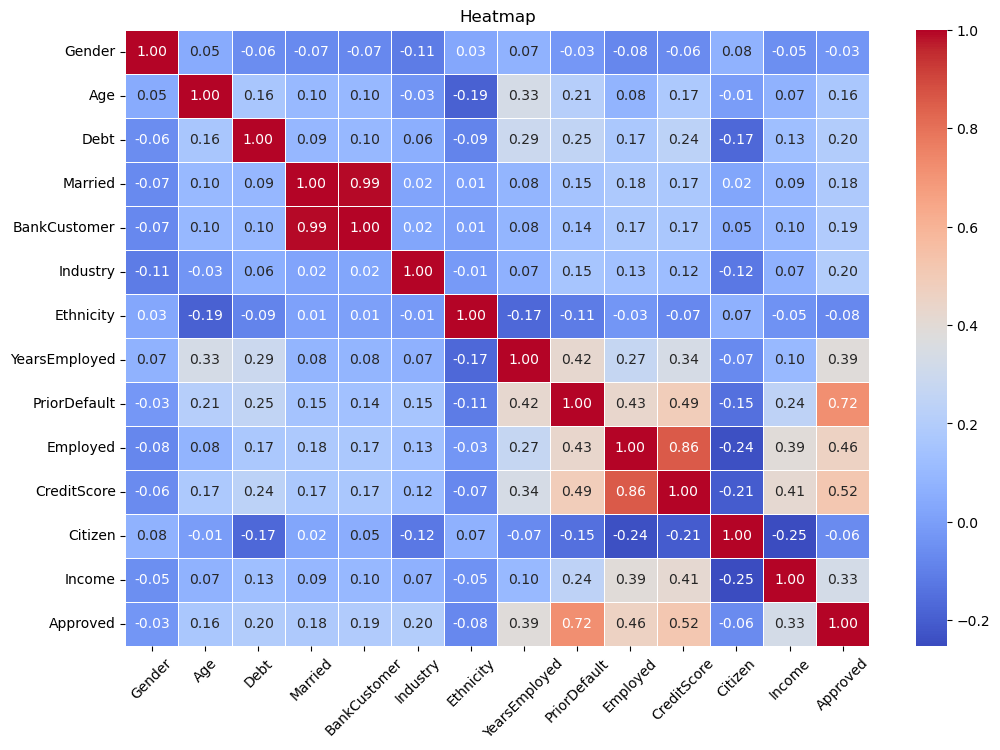

In [59]:

plt.figure(figsize=(12, 8))  # setting dimension for heatmap
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(rotation=45)  
plt.title("Heatmap")
plt.show()


In [60]:
df.to_csv("output_data.csv", index=False)


In [61]:
correlation = df[["Married", "BankCustomer"]].corr()
print(correlation)


               Married  BankCustomer
Married       1.000000      0.992033
BankCustomer  0.992033      1.000000


In [62]:
# check is those two columns are similar
identical_percentage = (df["Married"] == df["BankCustomer"]).sum() / len(df)
print(f"Identical: {identical_percentage * 100:.2f}%")


Identical: 99.71%


In [63]:
print(df["Married"].value_counts(normalize=True))
print(df["BankCustomer"].value_counts(normalize=True))


Married
1    0.76087
0    0.23913
Name: proportion, dtype: float64
BankCustomer
1    0.763768
0    0.236232
Name: proportion, dtype: float64


In [64]:

X = df.drop(columns=["Approved"])
y = df["Approved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = RandomForestClassifier(random_state=1)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)

# drop BankCustomer, beceause we don't need 2 similar columns
X_train = X_train.drop(columns=["BankCustomer"])
X_test = X_test.drop(columns=["BankCustomer"])

model2 = RandomForestClassifier(random_state=1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
acc2 = accuracy_score(y_test, y_pred2)

print(f"Accuracy with BankCustomer: {acc1:.4f}")
print(f"Accuracy wo BankCustomer: {acc2:.4f}")

Accuracy with BankCustomer: 0.8478
Accuracy wo BankCustomer: 0.8623


In [65]:
df.to_csv("output_data1.csv", index=False)

In [66]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClasifiction:\n", classification_report(y_true, y_pred))

    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}


In [67]:
metrics = evaluate_model(y_test, y_pred1)
metrics2 = evaluate_model(y_test, y_pred2)


Accuracy: 0.8478
Precision: 0.8551
Recall: 0.8429
F1-Score: 0.8489

Clasifiction:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85        68
           1       0.86      0.84      0.85        70

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.85      0.85      0.85       138

Accuracy: 0.8623
Precision: 0.8696
Recall: 0.8571
F1-Score: 0.8633

Clasifiction:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86        68
           1       0.87      0.86      0.86        70

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



In [70]:
# imports for classic models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# imports for other models (Gradient Boosting)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


models = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = evaluate_model(y_test, y_pred)

# create a label for comparison
comparison = pd.DataFrame(results).T
print(comparison)

Accuracy: 0.8696
Precision: 0.8824
Recall: 0.8571
F1-Score: 0.8696

Clasifiction:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        68
           1       0.88      0.86      0.87        70

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138

Accuracy: 0.8551
Precision: 0.8571
Recall: 0.8571
F1-Score: 0.8571

Clasifiction:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.86      0.86      0.86        70

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138

Accuracy: 0.8188
Precision: 0.8358
Recall: 0.8000
F1-Score: 0.8175

Clasifiction:
               precision    recall  f1-score   support

           0       0.80      0.84      0.8

In [72]:
joblib.dump(model, "credit_approval_model.pkl")

['credit_approval_model.pkl']